# Homework #5
Due 11:59 pm EST, Friday April 1st, 2022.

Email your solutions (both .ipnb and .html files) to: compscbio@gmail.com.

### Background:

That same sadistic post-doc in your lab has just read the RNA Velocity paper and is _even more_ excited about it than about Cytotrace. You decide to see how well Velocity pseudotime compares to Cytotrace score derived pseudotime using data for which you can reasonably anchor the starting point of the trajectory inference.

### The data
1. [The day 4 mESC data that we keep using over and over again](https://compstemcellbio.s3.amazonaws.com/2022/homework/05/adata_HW5_mESC_day4.h5ad)
This is the raw counts data, as well as spliced and unspliced counts. As in HW4, we have cleaned it (i.e. removed potential doublets, low quality cells, and mito, ribo and malat genes). In terms of pre-processing, all you have to do is deal with rarely detected genes and normalization.

2. There is _no_ second data set for this homework.


### Your mission:

Run your usual pre-processing, clustering and annotation. Perform Cytotrace analysis. Then run RNA velocity and plot the velocity embeddings on either (1) the 1st and 3rd principal components, or (2) the UMAP embedding (which you need to figure out how to make from the scanpy documentation). Then compute velocity pseudotime. Finally, as you did in HW4, compute diffusion based pseudotime. 

Determine how these three pseudotimes compare and produce an appropiate multi-panel figure to display them.

Is there a relationship between velocity confidence and discreptancies between velocity pseudotime and Cytotrace pseudotime and/or diffusion pseudotime?

In [1]:
# load in depends
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import scipy as sp
import numpy as np
import warnings

warnings.filterwarnings('ignore')

# NB these new packages
import scvelo as scv
import cellrank as cr

from cellrank.tl.kernels import CytoTRACEKernel

In [2]:
scv.settings.presenter_view = True
scv.set_figure_params('scvelo')

In [3]:
# read in the data hw5
adata = sc.read('adata_HW5_mESC_day4.h5ad')

In [4]:
# preprocessing, deal with rarely detected genes and normalization 
# removes rare genes and performs norm/log/hvg
def filterRareGenes_norm(anndata):
    # we need to deal with rarely detected genes and normalize
    adNorm = anndata.copy()

    # filter out rarely detected genes
    sc.pp.filter_genes(adNorm, min_cells=5)

    # norm/log/hvg
    sc.pp.normalize_per_cell(adNorm, counts_per_cell_after=1e4)
    sc.pp.log1p(adNorm)
    sc.pp.highly_variable_genes(adNorm, min_mean=0.0125, max_mean=5, min_disp=0.25)
    
    return adNorm

In [5]:
# run our function to deal with rarely detected genes and normalize 
adNorm = filterRareGenes_norm(adata)

In [6]:
adata

AnnData object with n_obs × n_vars = 5134 × 24172
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

In [7]:
adNorm

AnnData object with n_obs × n_vars = 5134 × 14202
    obs: 'n_counts'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

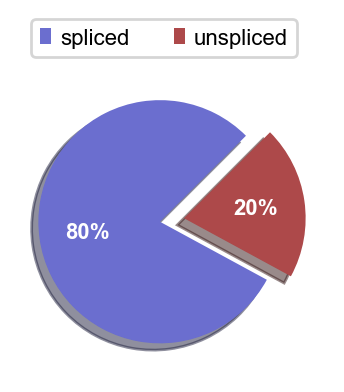

In [8]:
# view proport spliced vs unspliced
scv.pl.proportions(adNorm)

In [9]:
# This is a necessary hack. See CellRank docs
# function to perform the hack from lecture
def hack(adM1Norm):
    # This is a necessary hack. See CellRank docs
    adM1Norm.layers["spliced"] = adM1Norm.X
    adM1Norm.layers["unspliced"] = adM1Norm.X
    scv.pp.moments(adM1Norm, n_pcs=30, n_neighbors=30)

In [10]:
hack(adNorm)

computing neighbors


OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


    finished (0:00:06) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:03) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [11]:
ctk = CytoTRACEKernel(adNorm)

In [12]:
# scale, compute, and plot pca vs var ratio
def scalePCA(adM1Norm):
    sc.pp.scale(adM1Norm, max_value=10)
    sc.tl.pca(adM1Norm, n_comps=100)
    sc.set_figure_params(figsize="10, 4")
    sc.pl.pca_variance_ratio(adM1Norm, 100)

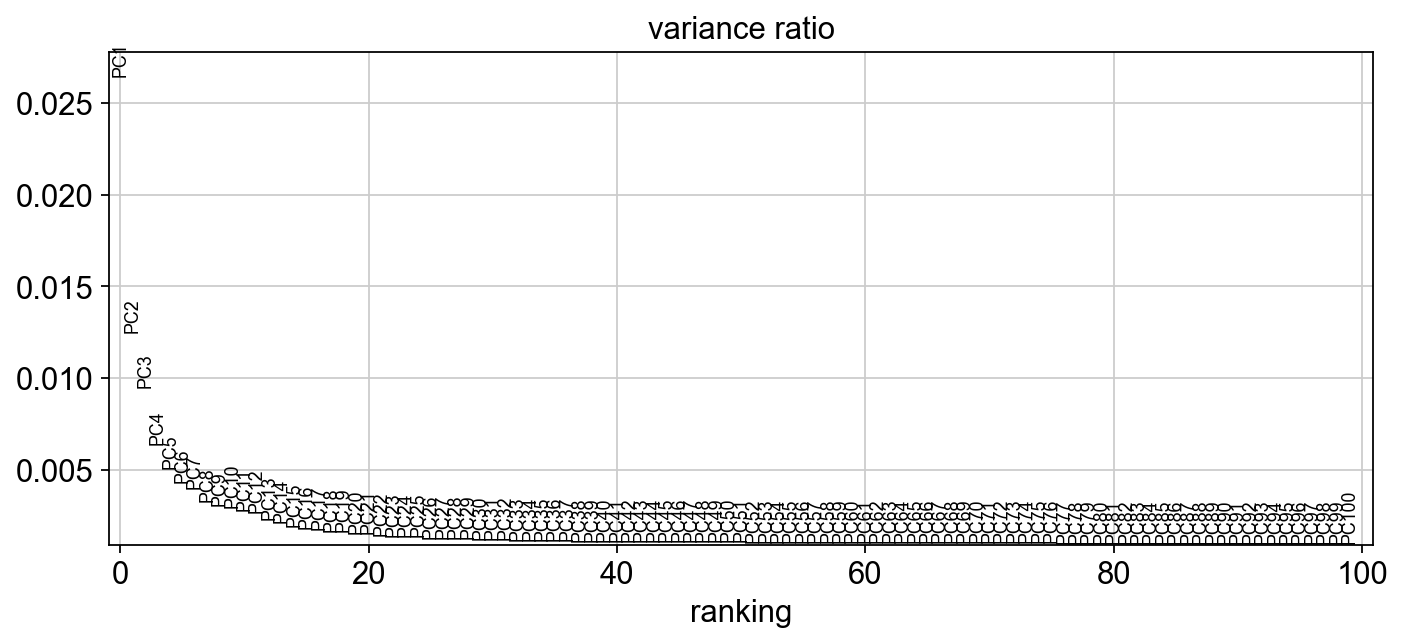

In [13]:
scalePCA(adNorm)

In [14]:
# compute leiden
def compLeiden(adM1Norm, npcs = 15, nknns = 15):
    sc.pp.neighbors(adM1Norm, n_neighbors=nknns, n_pcs=npcs)
    sc.tl.leiden(adM1Norm,.25)
    
    
# plot leiden
def plotLeiden(adM1Norm):
    fig, axs = plt.subplots(1,2, figsize=(10,5), constrained_layout=True)
    sc.pl.pca(adM1Norm, color=["leiden"], alpha=.7, s=20, components="1,2",legend_loc='on data', ax=axs[0], show=False)
    sc.pl.pca(adM1Norm, color=["leiden"], alpha=.7, s=20, components="1,3",legend_loc='on data', ax=axs[1], show=False)

In [16]:
compLeiden(adNorm)

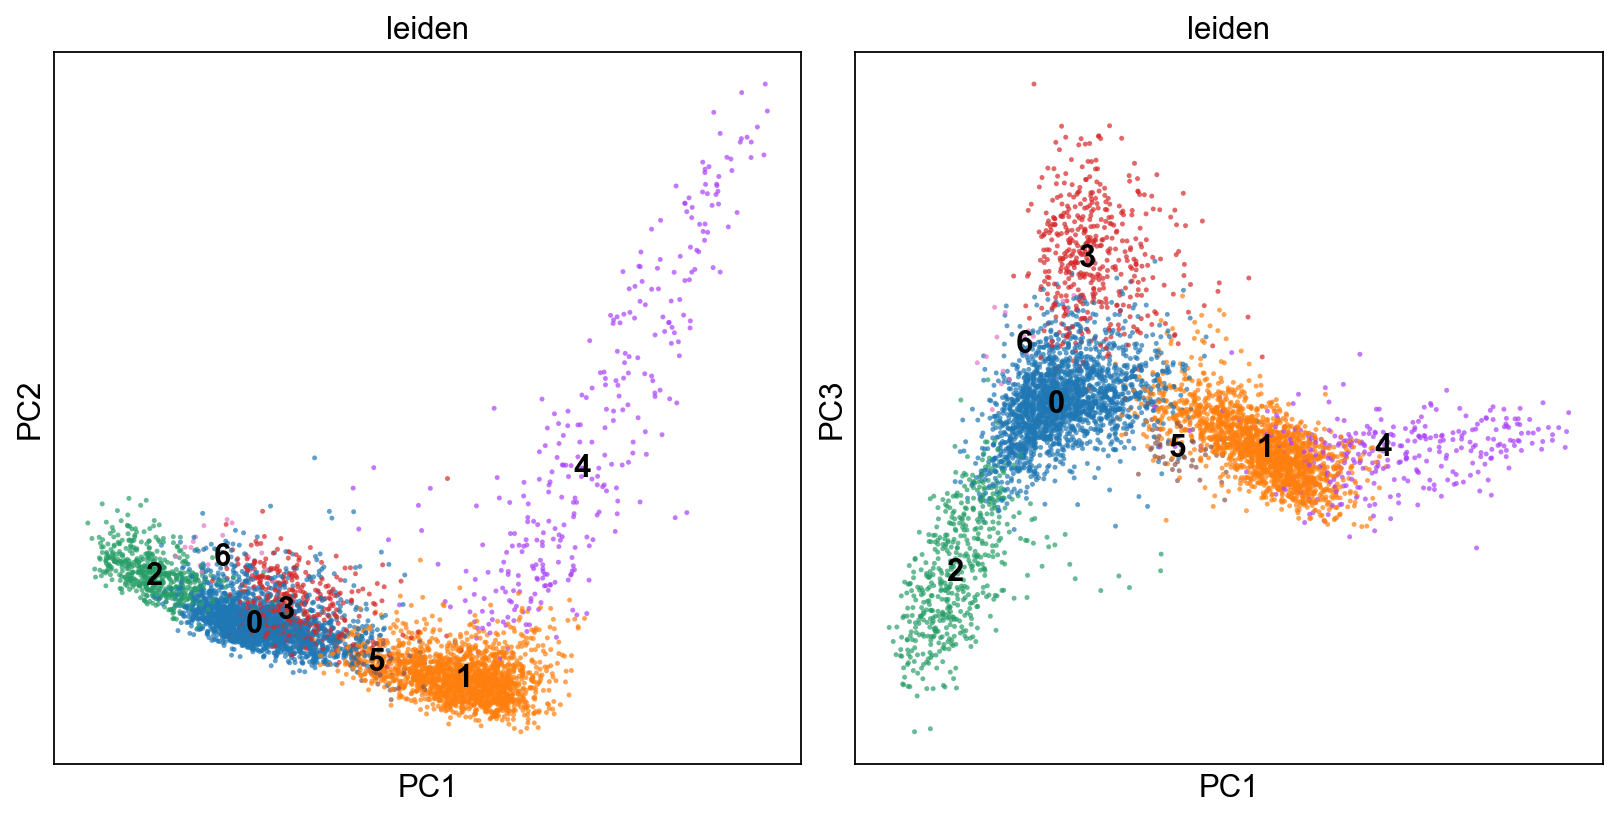

In [17]:
plotLeiden(adNorm)

In [18]:
# plot leiden colored by pseudotime (PDT) and ct_score
def plotLeidenPDT(adM1Norm):
    fig, axs = plt.subplots(1,2, figsize=(10,5), constrained_layout=True)
    sc.pl.pca(adM1Norm, color=["ct_pseudotime"], alpha=.7, s=20, components="1,3",legend_loc='on data', ax=axs[0], show=False)
    sc.pl.pca(adM1Norm, color=["ct_score"], alpha=.7, s=20, components="1,3",legend_loc='on data', ax=axs[1], show=False)

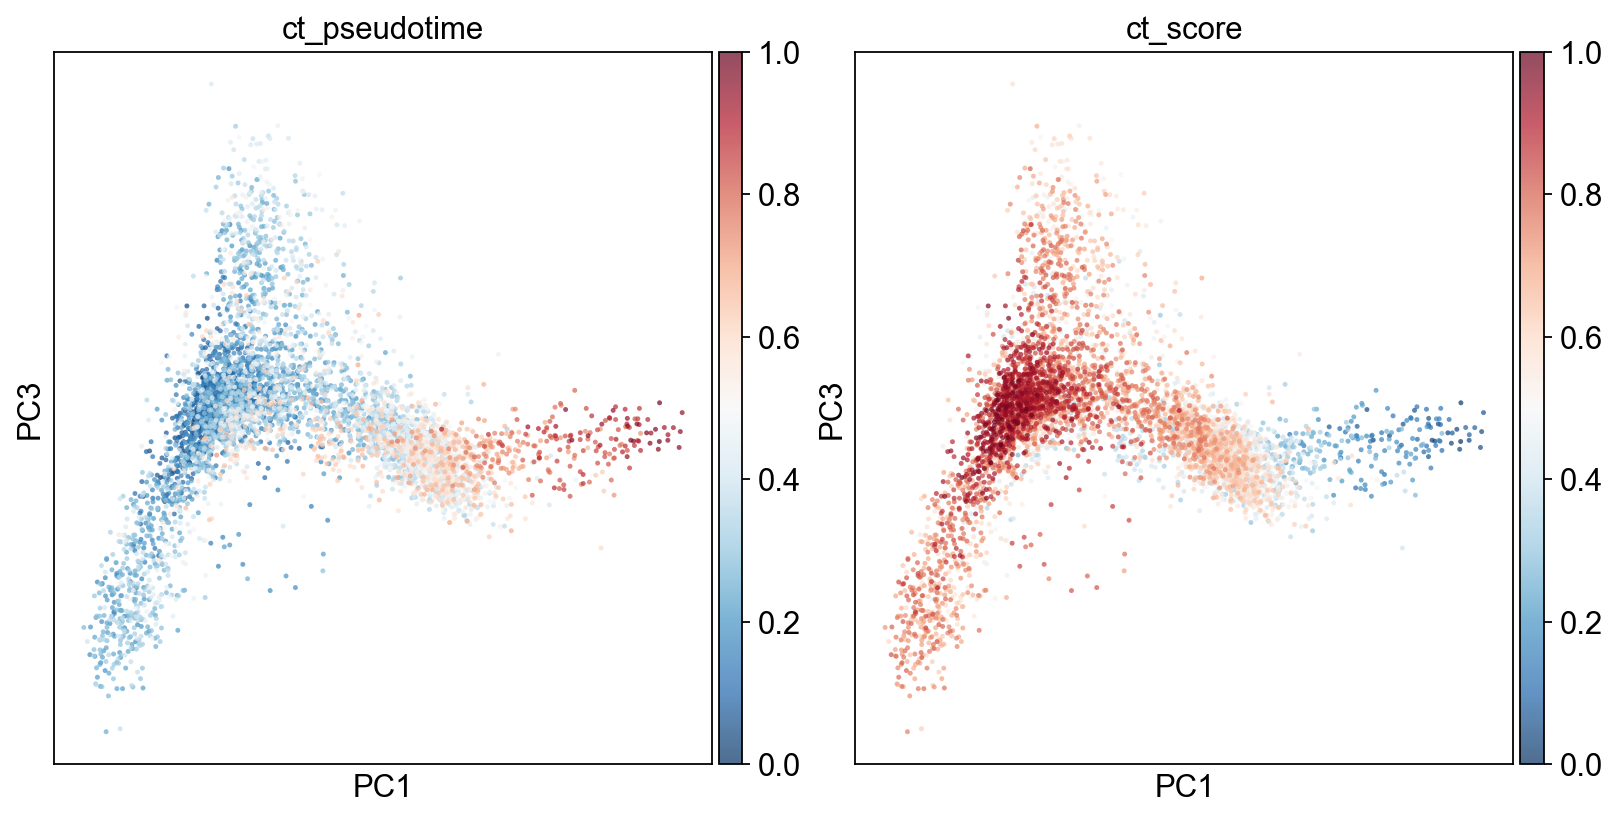

In [19]:
plotLeidenPDT(adNorm)

In [20]:
ad4X = adNorm

In [21]:
# rank genes and dotplot em
def rankGenes_dpt(adM1X):
    sc.tl.rank_genes_groups(adM1X, 'leiden')
    sc.pl.rank_genes_groups_dotplot(adM1X, n_genes=8, groupby='leiden', use_raw=False, dendrogram=False)

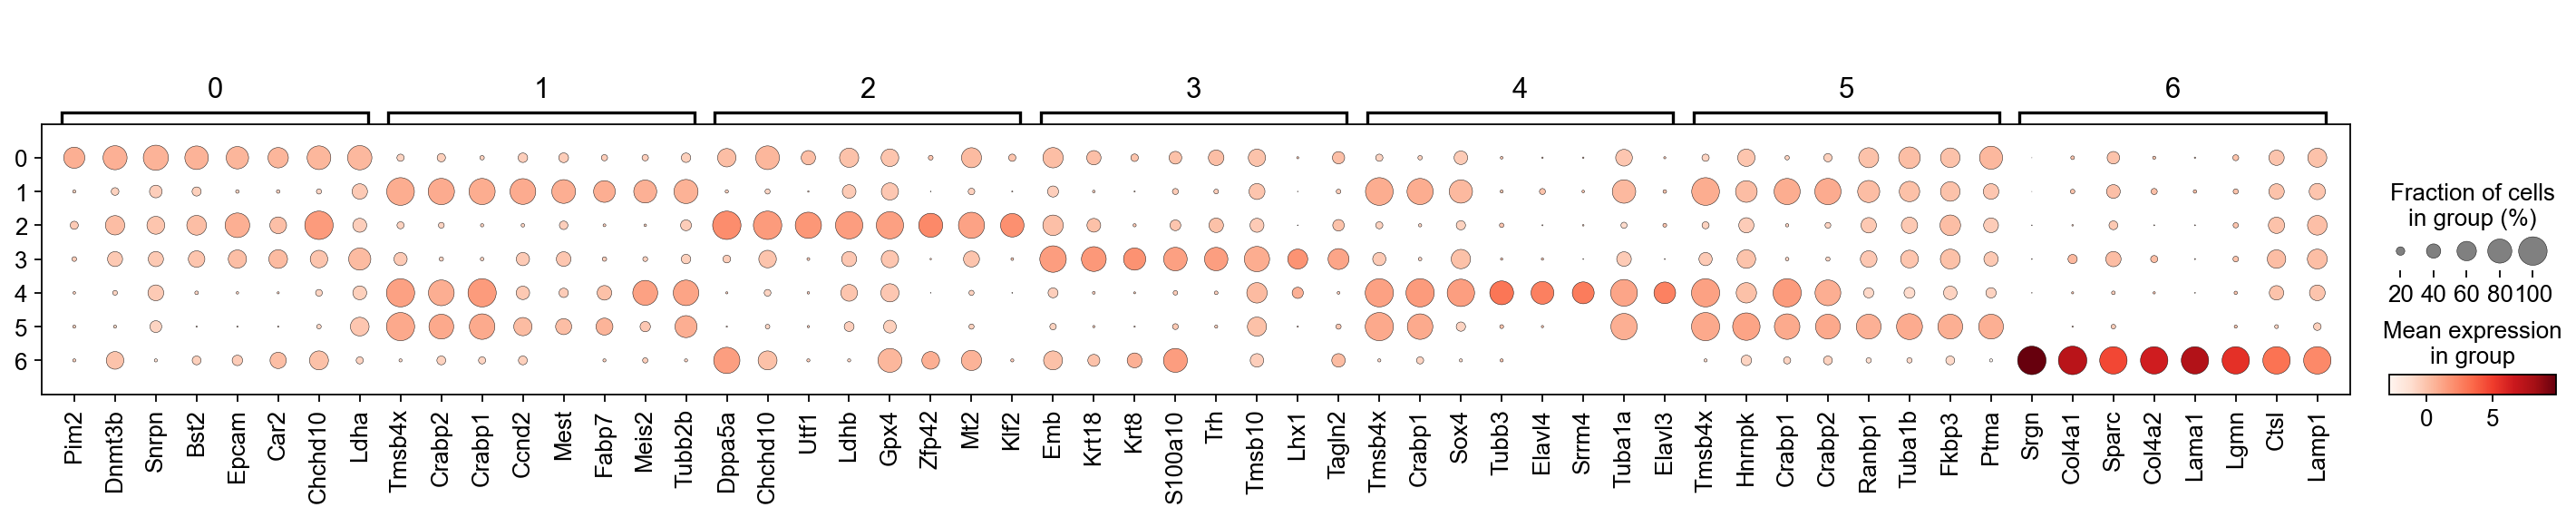

In [22]:
rankGenes_dpt(ad4X)

In [23]:
# compute diff map and plot 
def diffMap(adM1X):
    sc.tl.diffmap(adM1X)
    sc.set_figure_params(figsize="6,6")
    sc.pl.diffmap(adM1X, color="leiden", components=["1,3"], legend_loc="on data")

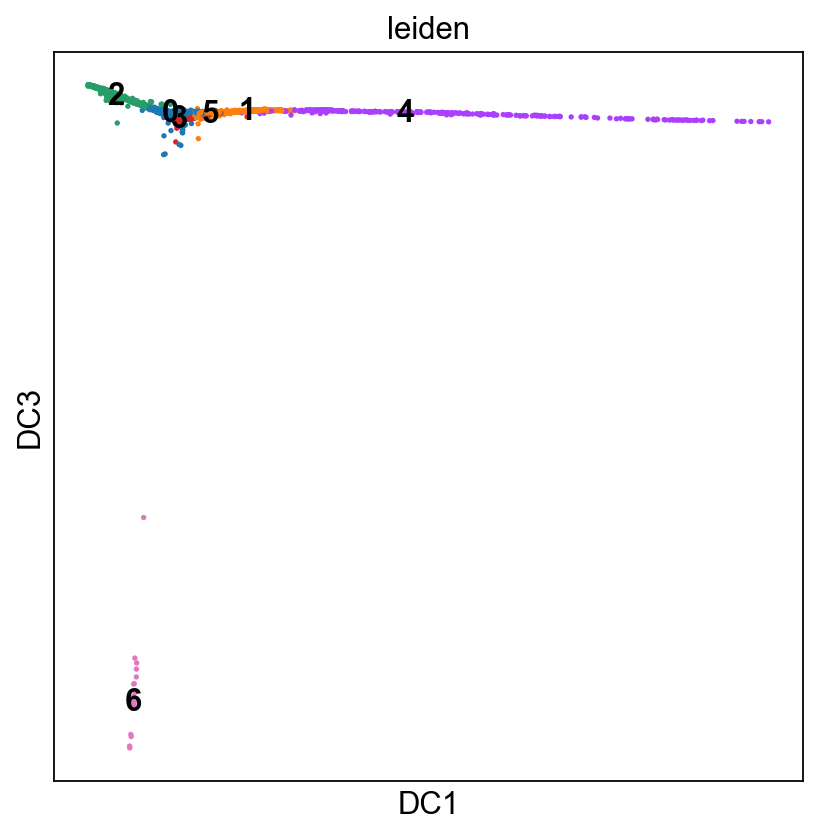

In [24]:
diffMap(ad4X)

In [25]:
def findRoot(anndata):
    # genes_plur is naive and primed genesets combined 
    pluri_genes = [x.strip() for x in open("genes_pluri.csv")]
    sc.tl.score_genes(anndata, gene_list = pluri_genes, score_name = "pluri_genesets", use_raw=False)
    print(anndata.obs.groupby('leiden').agg({'pluri_genesets':'mean'}))

In [26]:
findRoot(ad4X)

        pluri_genesets
leiden                
0             0.117798
1            -0.261034
2             0.644432
3            -0.108912
4            -0.186826
5            -0.167504
6            -0.046746


In [27]:
# define the root 
# ad4X.uns['iroot'] = np.flatnonzero(ad4X.obs['leiden']  == 'Primed')[0]
# define root following the lecture

# after speaking with Dan, he informed me that the cluster with the highest expr of pluri genes should be classified as the root
# this makes sense as other cells are 'more differentiated' that the most pluri cells and should stem off them 
# i will be applying this logic for the next datasets as well
# define root by picking cluster with highest mean plur geneset score, here it is cluster 2
ad4X.uns['iroot'] = np.flatnonzero(ad4X.obs['leiden']  == '2')[0]
sc.tl.dpt(ad4X)

## We will plot everything together at the end

In [28]:
ad4X.obs

n_counts  ct_num_exp_genes  ct_score  \
CellID                                                              
Cahan_PCG45:AAACATACCCTACCx    1243.0               950  0.250225   
Cahan_PCG45:AAACATACGTCGTAx    2081.0              1291  0.599170   
Cahan_PCG45:AAACATACTTTCACx    2075.0              1270  0.809371   
Cahan_PCG45:AAACATTGCATTGGx    1415.0               971  0.318060   
Cahan_PCG45:AAACATTGCTTGCCx    5398.0              2222  0.794671   
...                               ...               ...       ...   
Cahan_PCG45:TTTGACTGACTCTTx    5743.0              2459  0.793511   
Cahan_PCG45:TTTGACTGAGGCGAx    4115.0              2041  0.750373   
Cahan_PCG45:TTTGACTGCATTGGx    5263.0              2439  0.694955   
Cahan_PCG45:TTTGACTGCTGGATx    1799.0              1193  0.564166   
Cahan_PCG45:TTTGACTGGTGAGGx    5087.0              2351  0.779593   

                             ct_pseudotime leiden  pluri_genesets  \
CellID                                                              
Cahan_PCG45:AAACATACCCTACCx       0.749775      1       -0.259624   
Cahan_PCG45:AAACATACGTCGTAx       0.400830      0        0.686409   
Cahan_PCG45:AAACATACTTTCACx       0.190629      0        0.903871   
Cahan_PCG45:AAACATTGCATTGGx       0.681940      4       -0.334898   
Cahan_PCG45:AAACATTGCTTGCCx       0.205329      0       -0.139733   
...                                    ...    ...             ...   
Cahan_PCG45:TTTGACTGACTCTTx       0.206489      0        0.005352   
Cahan_PCG45:TTTGACTGAGGCGAx       0.249627      1        0.045746   
Cahan_PCG45:TTTGACTGCATTGGx       0.305045      2        1.868998   
Cahan_PCG45:TTTGACTGCTGGATx       0.435834      2        0.421509   
Cahan_PCG45:TTTGACTGGTGAGGx       0.220407      1       -0.377365   

                             dpt_pseudotime  
CellID                                       
Cahan_PCG45:AAACATACCCTACCx        0.323144  
Cahan_PCG45:AAACATACGTCGTAx        0.225484  
Cahan_PCG45:AAACATACTTTCACx        0.230899  
Cahan_PCG45:AAACATTGCATTGGx        0.372722  
Cahan_PCG45:AAACATTGCTTGCCx        0.251397  
...                                     ...  
Cahan_PCG45:TTTGACTGACTCTTx        0.229059  
Cahan_PCG45:TTTGACTGAGGCGAx        0.284692  
Cahan_PCG45:TTTGACTGCATTGGx        0.064165  
Cahan_PCG45:TTTGACTGCTGGATx        0.171318  
Cahan_PCG45:TTTGACTGGTGAGGx        0.262276  

[5134 rows x 7 columns]

In [29]:
def splice_unspliceNorm(anndata):
    scv.pp.filter_genes(anndata, min_shared_counts=20)
    scv.pp.normalize_per_cell(anndata)
    scv.pp.filter_genes_dispersion(anndata, n_top_genes=2000)
    scv.pp.log1p(anndata)
    return anndata

In [30]:
# smoothing 
scv.pp.filter_and_normalize(ad4X, min_shared_counts=20, n_top_genes=2000) # does same as above function
scv.pp.moments(ad4X, n_pcs=30, n_neighbors=30)
ad4X

Filtered out 707 genes that are detected 20 counts (shared).
Extracted 11195 highly variable genes.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:02) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


AnnData object with n_obs × n_vars = 5134 × 11195
    obs: 'n_counts', 'ct_num_exp_genes', 'ct_score', 'ct_pseudotime', 'leiden', 'pluri_genesets', 'dpt_pseudotime', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'ct_gene_corr', 'ct_correlates', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'ct_params', 'leiden', 'leiden_colors', 'rank_genes_groups', 'diffmap_evals', 'iroot'
    obsm: 'X_pca', 'X_diffmap'
    varm: 'PCs'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced', 'Ms', 'Mu'
    obsp: 'distances', 'connectivities'

In [31]:
sc.tl.umap(ad4X)

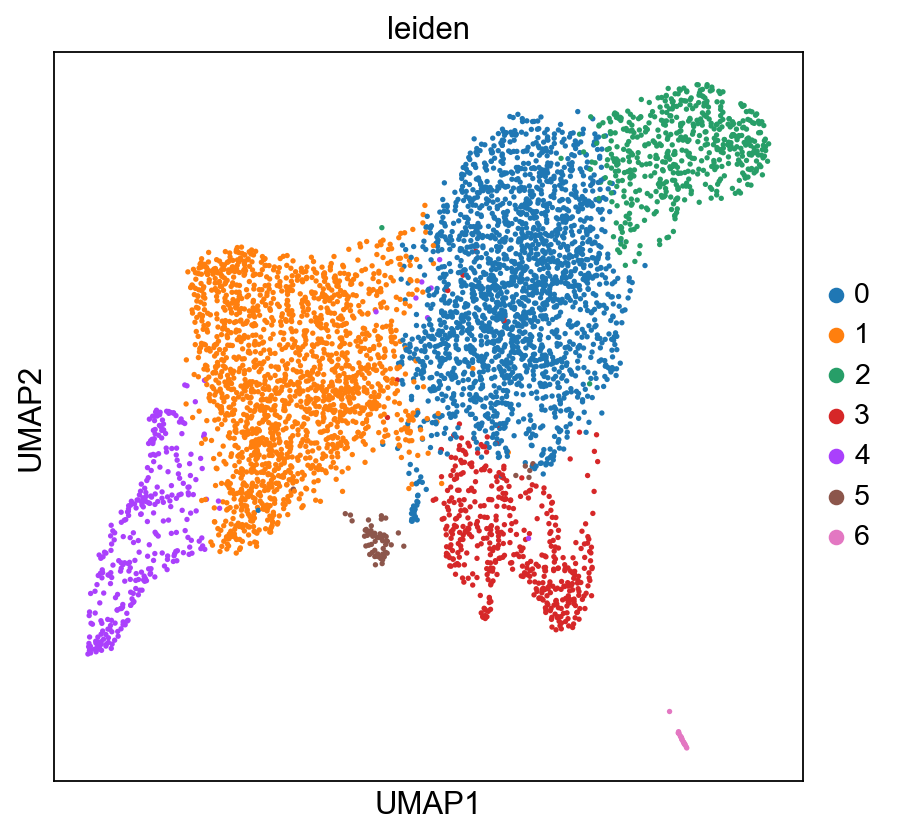

In [32]:
sc.pl.umap(ad4X, color = 'leiden')

In [33]:
# adata = sc.read_h5ad('adata_HW5_mESC_day4.h5ad')

In [34]:
# compute velocity 
scv.tl.velocity(ad4X)

computing velocities
    finished (0:00:09) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [35]:
scv.tl.velocity_graph(ad4X, n_jobs=-1) # changed to -1 but ran with -2

computing velocity graph (using 9/10 cores)


  0%|          | 0/5134 [00:00<?, ?cells/s]

/opt/anaconda3/lib/python3.9/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res


    finished (0:00:50) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


In [36]:
scv.pl.velocity_embedding(ad4X, arrow_length=3, arrow_size=2, dpi=120, color='leiden')

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


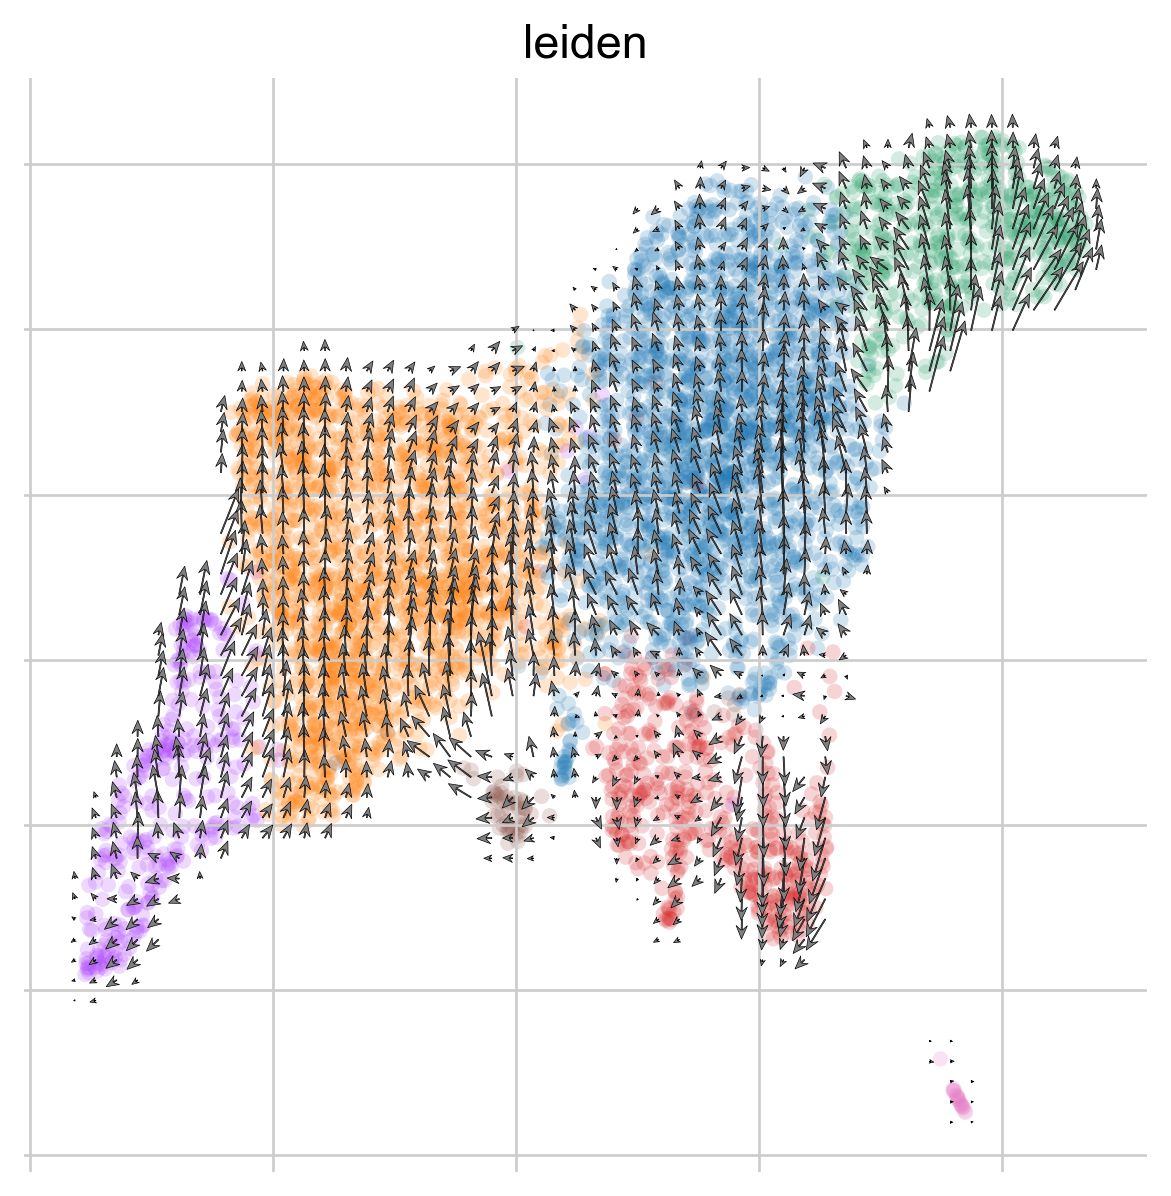

In [37]:
scv.pl.velocity_embedding_grid(ad4X, arrow_length=3, arrow_size=2, dpi=120, color='leiden')

In [38]:
scv.pl.velocity_embedding_stream(ad4X, basis='umap', color='leiden')

Above we have velocity embeddings on plotted umap in different formats (reg, grid, and stream). This allows us to see the 'flow'/transitions of the cells and the potential states they will be moving to since sc-rna-seq is a snapshot of gene expression of our samples frozen in time.

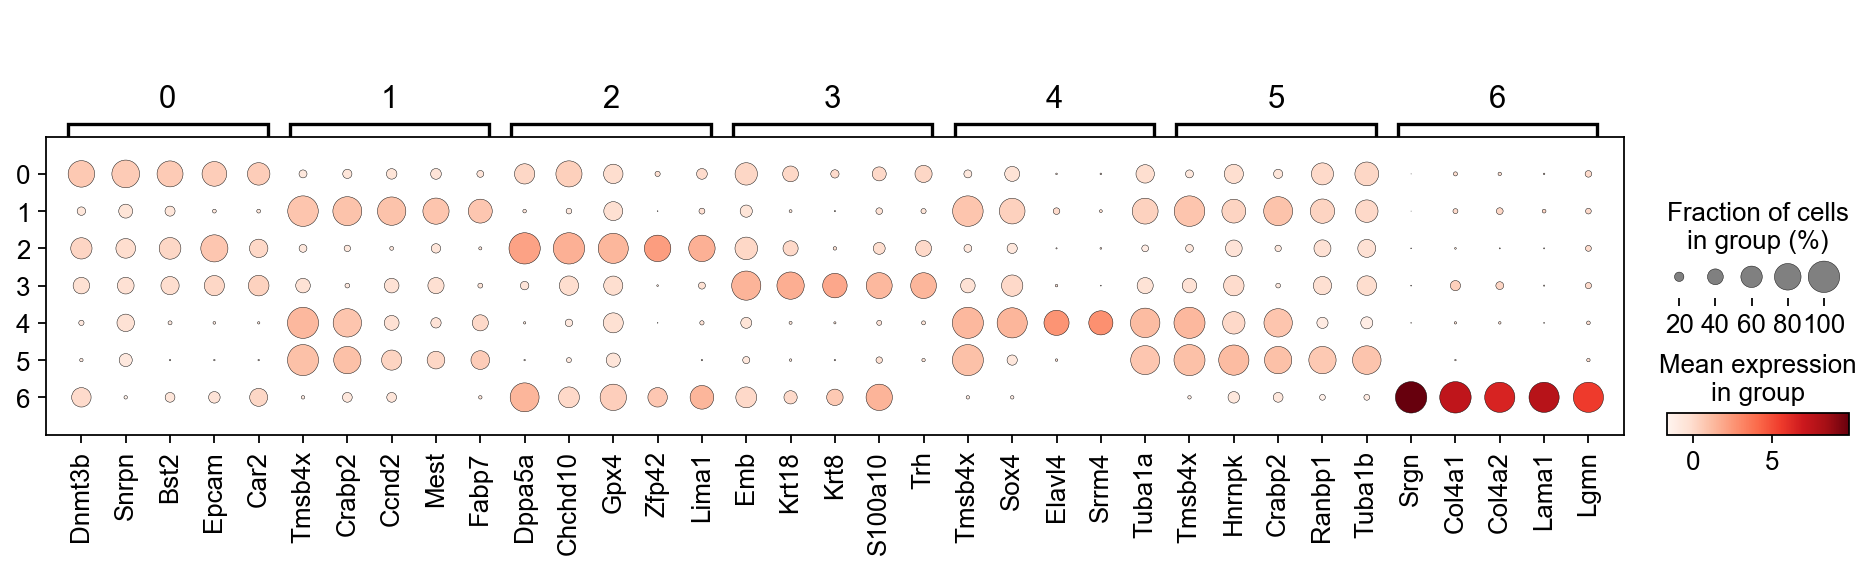

In [39]:
sc.tl.rank_genes_groups(ad4X,'leiden', use_raw=False)
sc.pl.rank_genes_groups_dotplot(ad4X, n_genes=5, groupby='leiden', use_raw=False, dendrogram=False)

In [40]:
# compute velocity pdt
scv.tl.velocity_pseudotime(ad4X)
scv.pl.scatter(ad4X, color='velocity_pseudotime', cmap='gnuplot')

computing terminal states
    identified 2 regions of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)


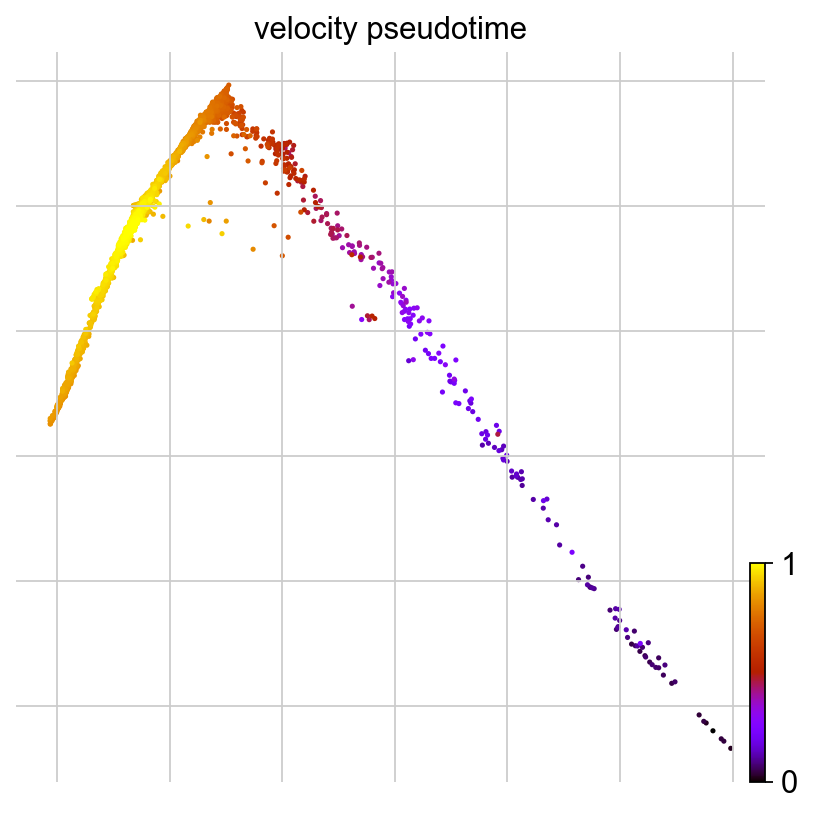

In [41]:
scv.pl.scatter(ad4X, color='velocity_pseudotime', cmap='gnuplot', basis = 'diffmap')

In [42]:
# plot comparisons velocity pdt vs ct pdt and velocity pdt vs dpt 
def comparePlots2(adM1X):
    # plot dpt pdt vs ct pdt
    sc.pl.diffmap(adM1X, color=["velocity_pseudotime","ct_pseudotime"], components=("1,2"), legend_loc='on data', cmap='gnuplot')
    sc.pl.diffmap(adM1X, color=["velocity_pseudotime","ct_pseudotime"], components=("1,3"), legend_loc='on data', cmap='gnuplot')
    sc.pl.diffmap(adM1X, color=["velocity_pseudotime","dpt_pseudotime"], components=("1,2"), legend_loc='on data', cmap='gnuplot')
    sc.pl.diffmap(adM1X, color=["velocity_pseudotime","dpt_pseudotime"], components=("1,3"), legend_loc='on data', cmap='gnuplot')
    sc.pl.violin(adM1X, "velocity_pseudotime", groupby="leiden")
    sc.pl.violin(adM1X, "dpt_pseudotime", groupby="leiden")
    sc.pl.violin(adM1X, "ct_pseudotime", groupby="leiden")
    sc.pl.diffmap(adM1X, color=['leiden','velocity_pseudotime', "dpt_pseudotime", "ct_pseudotime"], alpha=.9, s=35, projection='3d')

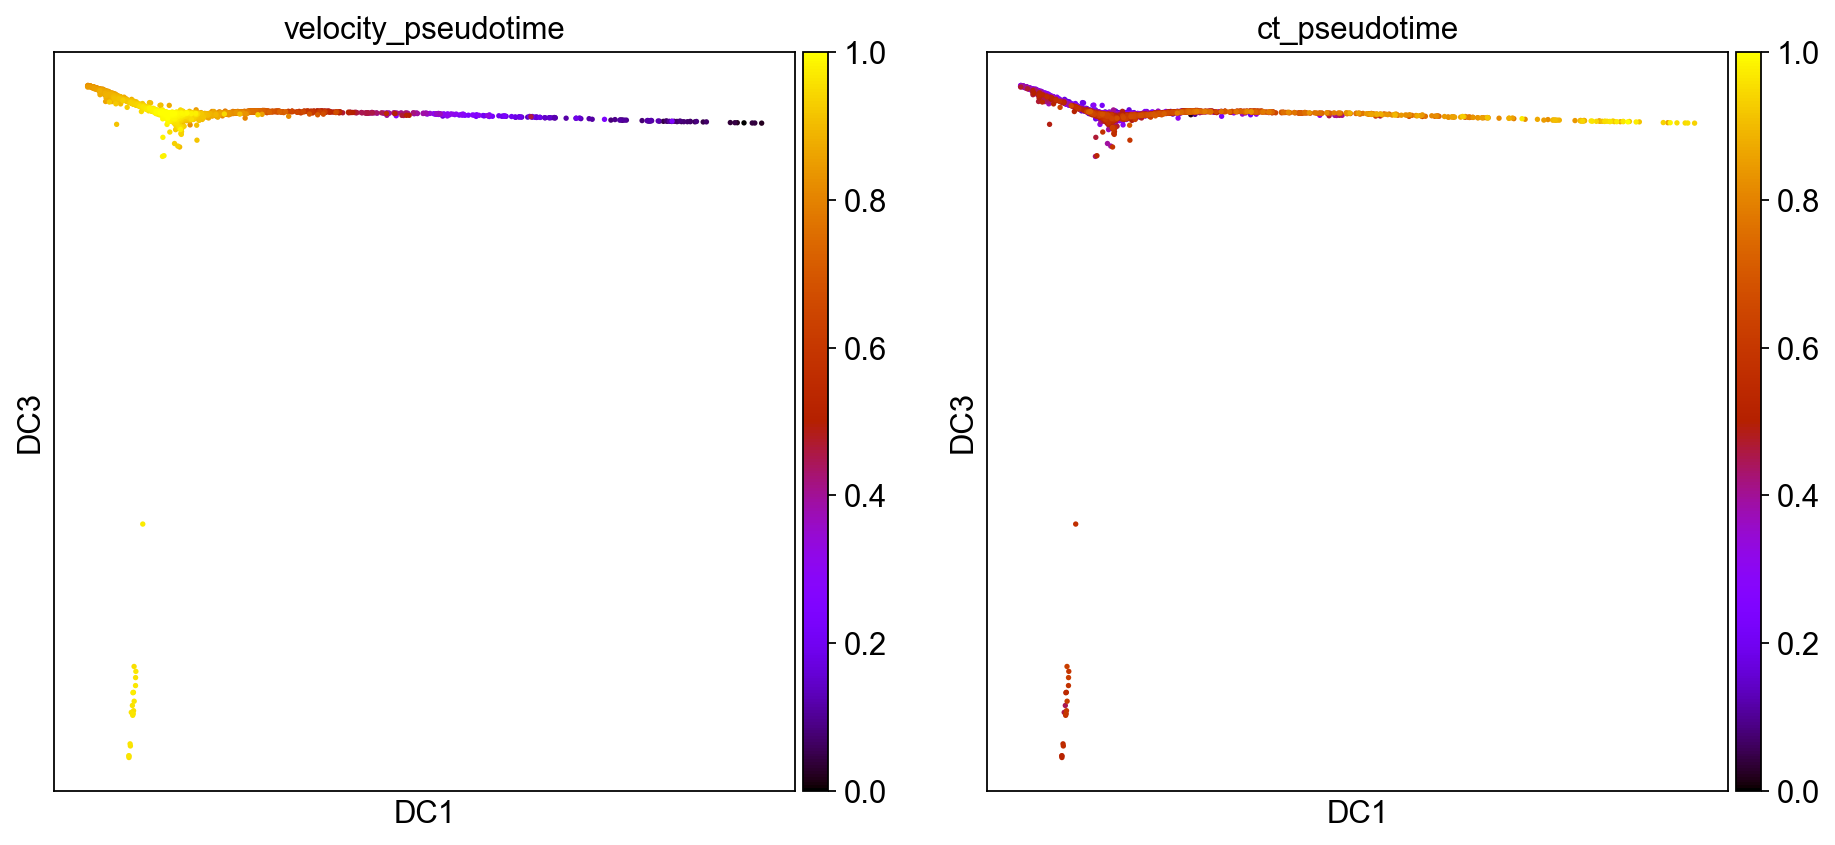

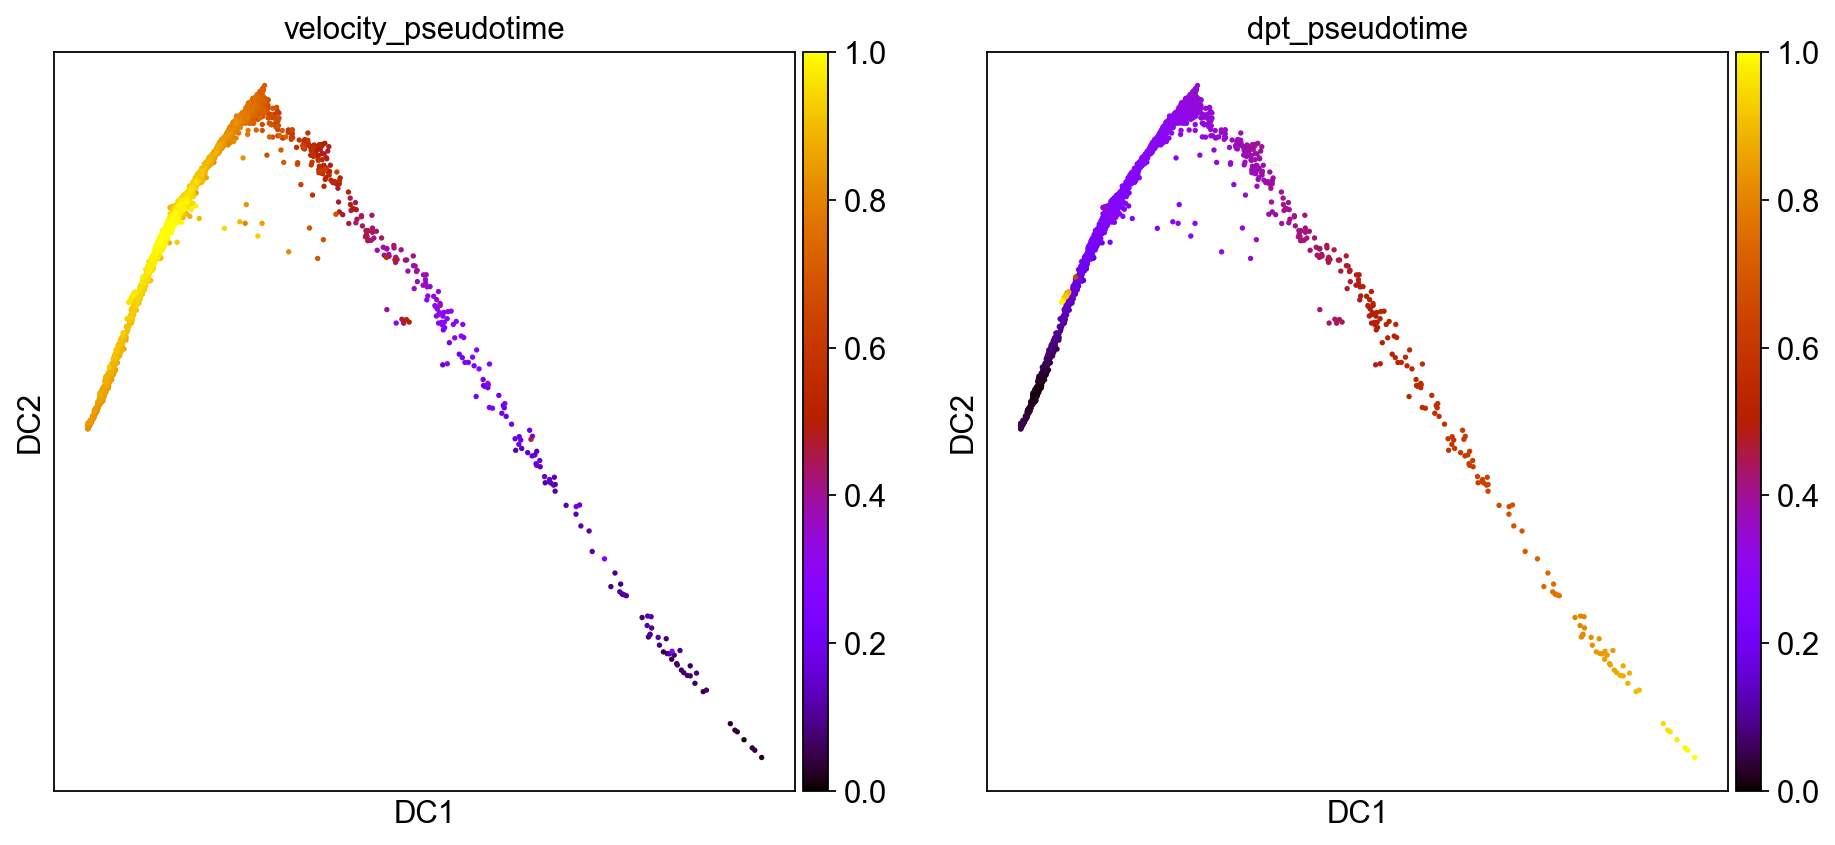

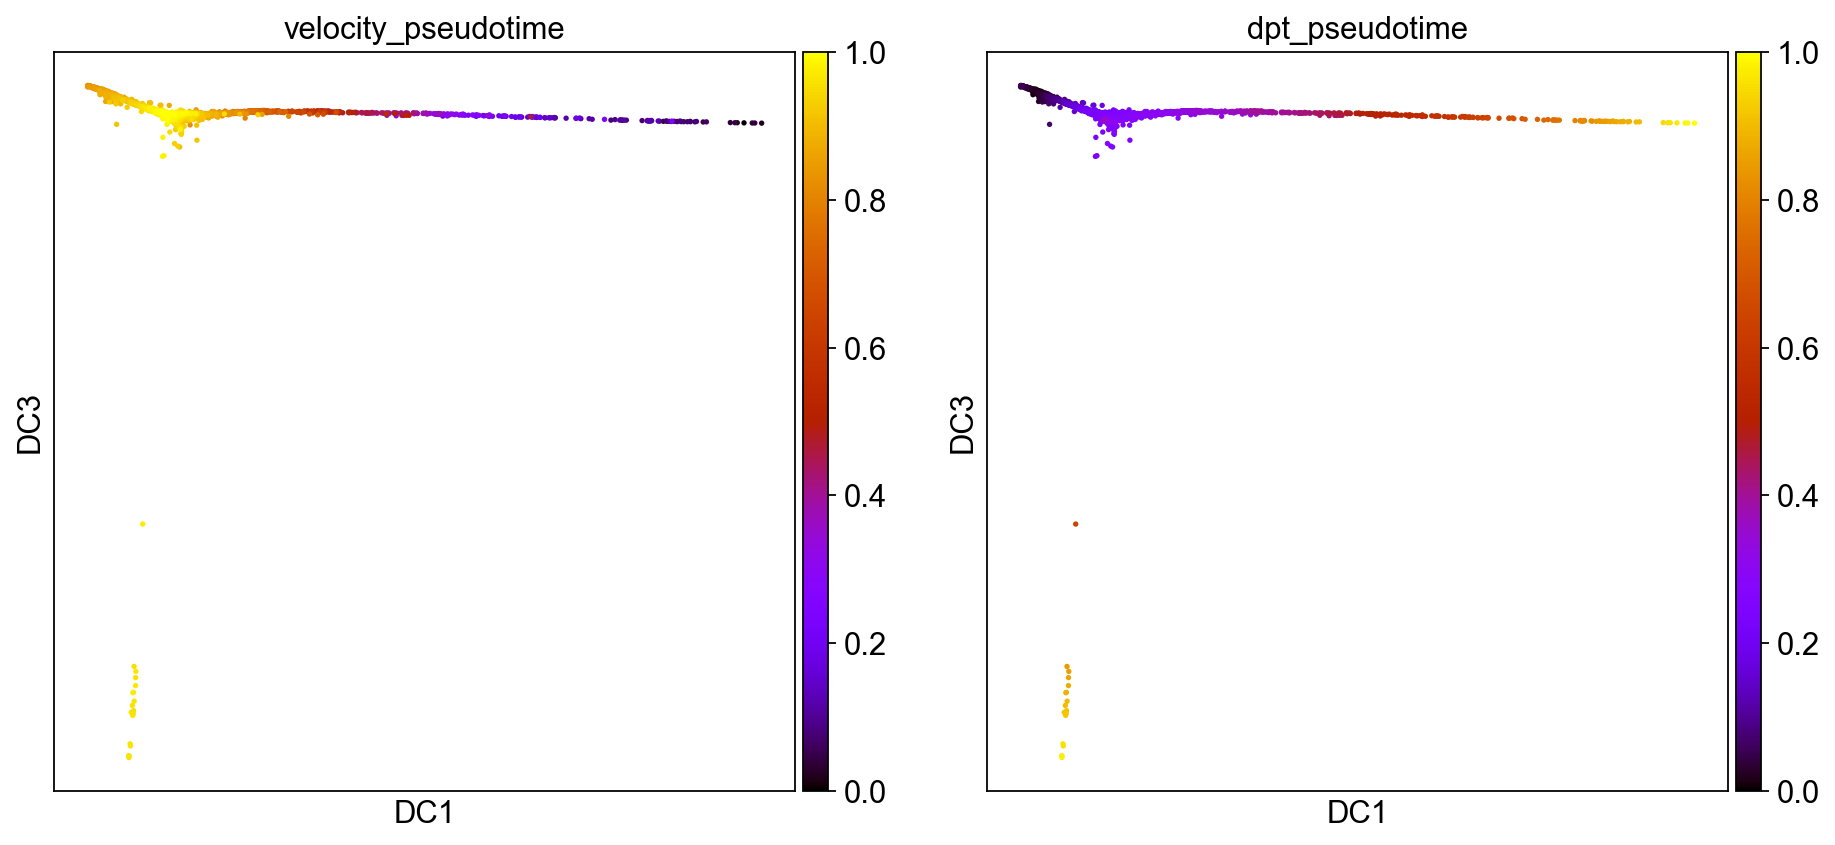

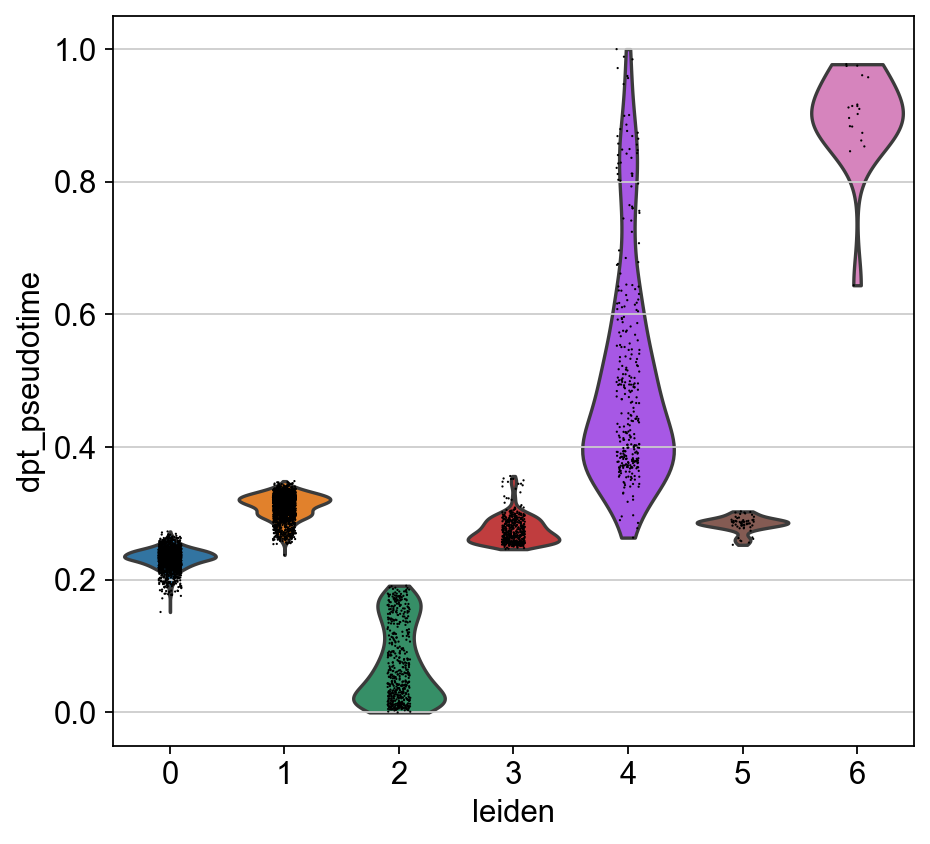

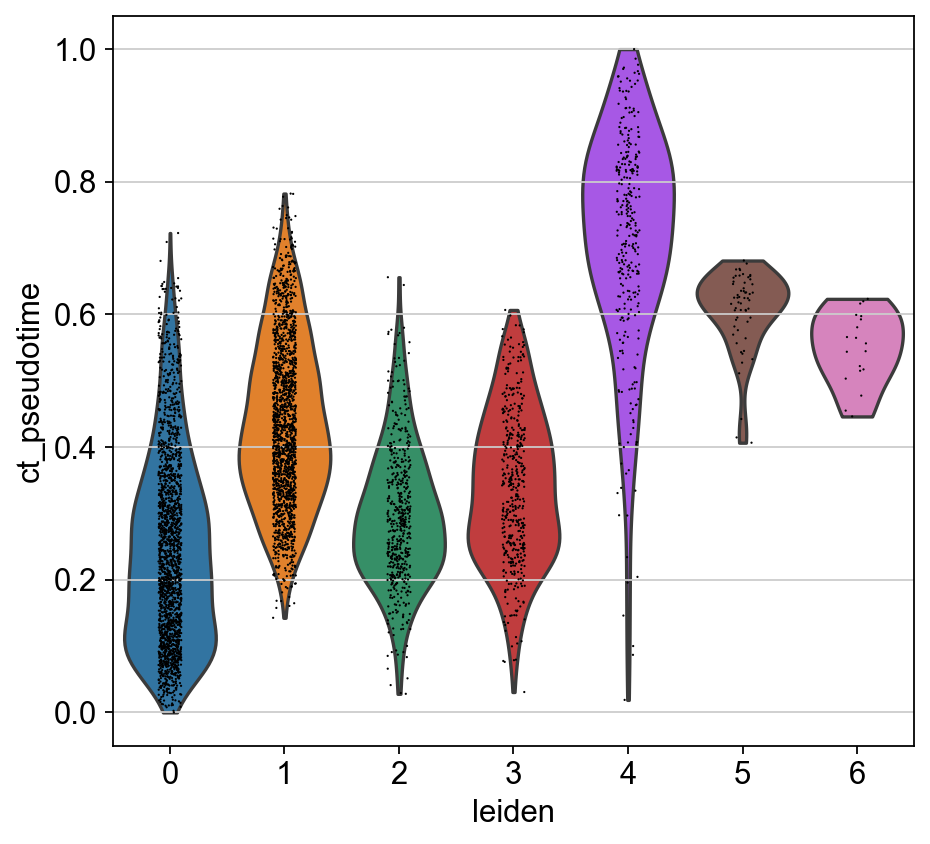

In [43]:
comparePlots2(ad4X)

### COMMENTS
Looking at both the 2d and 3d scatter plots, we can see that velocity pdt differs the most from the others. Velo pdt's are look 'reversed' when compared to the other two. In the 2d graphs we can see that velo pdt goes from 1 to 0 as move from left to right while the other 2 go from 0 to 1 as we move from left to right (ie the cells closer to the left of the graph are assigned higher pdts in velo while in ct and dpt, pdt assigned is lower the further left you go). 

#### velo vs dpt violin plots
In these plots we can see that velo pdt's for leidens 0,1,2,3, and 5 are much higher than dpt, while velo's pdt for leiden 4 is shifted down (base of violins looks pretty close though .4-.6). Leiden 6 pdt is slightly higher for velo.

#### velo vs ct violin plots
For leidens 0,1,2,3,5 and 6, ct pdts are more spread out than velo's. These leidens are also assigned much lower pdt's than in velo. For leiden 4, it almost looks like the violin was flipped across the x-axis as velos pdt's for leiden 4 have a lower base and higher tip while ct is the opposite.

### Trust
I think I would trust dpt or ct more than velo because I am pretty sure that dpt root is identified correctly with my function and ct looks more like dpt than velo. Maybe if we invert velo it would be more trustworthy? I've heard that there are some problems with rna velocity computations (Loyal Goff). Dr. Loyal Goff also provided the following paper detailing rna velo and some of its issues: https://www.biorxiv.org/content/10.1101/2022.02.12.480214v1 

# Bonus
•	Bonus 2pts The assumptions of splicing-based velocity estimation do not hold for all genes. Explain in detail how scVelo addresses this. In particular, does the function “scv.tl.velocity” involve any filtering to remove genes with poor fit? If yes, how does it work? If not, does filtering happen anywhere else in the pipeline? For an example of something similar in a different software tool, look up the argument “min.nmat.emat.correlation” in the function “gene.relative.velocity.estimates” from the R package “velocyto.r” (docs here) and its scientific justification in extended data figure 3, panel e in La Manno et al.

min.nmat.emat.correlation: minimum required Spearman rank correlation between n and e counts of a gene


The linked tool requires a minimun spearman rank correlation between spliced and unspliced counts of a gene for it to be included

Looking that scv.tl.velocity docs, it does not seem like the command itself does any filtering. What it does do is 'determine velocities by quantifying how observations deviate from a presumed steady-state equilibrium ratio of unspliced to spliced mRNA levels. This steady-state ratio is obtained by performing a linear regression restricting the input data to the extreme quantiles. By including second-order moments, the stochastic model [Bergen19] exploits not only the balance of unspliced to spliced mRNA levels but also their covariation. By contrast, the likelihood-based dynamical model [Bergen19] solves the full splicing kinetics and generalizes RNA velocity estimation to transient systems. It is also capable of capturing non-observed steady states.' https://scvelo.readthedocs.io/scvelo.tl.velocity/

Although it does 'restrict input data to the extreme quantiles', I believe this is not done when running the command itself as hvg default is true. hvg is calculated prior to running this command. Instead, this is done with the command scvelo.pp.filter_and_normalize. This is the step where our genes are filtered and hvgs are identified. This command runs the following code:
```
scv.pp.filter_genes(adata)
scv.pp.normalize_per_cell(adata)
if n_top_genes is not None:
    scv.pp.filter_genes_dispersion(adata)
if log:
    scv.pp.log1p(adata)
```

I believe the command scv.pp.filter_genes is where the bad genes would be filtered out.
'Filter genes based on number of cells or counts. Keep genes that have at least min_counts counts or are expressed in at least min_cells cells or have at most max_counts counts or are expressed in at most max_cells cells. Only provide one of the optional parameters min_counts, min_cells, max_counts, max_cells per call.' 
https://scvelo.readthedocs.io/scvelo.pp.filter_genes/



But since all of the default parameters in the function filter_genes are none. I think that scv.tl.velocity relies on hvg's in order to calculate velocities. This is done with the command scv.pp.filter_genes_dispersion which is ran when you use scv.pp.filter_and_normalize. This should be all the 'filtering of bad genes' that scv.tl.velocity needs as it 'restricts input data to the extreme quantiles' anyway.

The final preprocessing step before running scv.tl.velocity is scv.pp.moments. This command 'Computes moments for velocity estimation.

First-/second-order moments are computed for each cell across its nearest neighbors, where the neighbor graph is obtained from euclidean distances in PCA space.' Like scv.tl.velocity, use hvg default is true. This means that only hvgs are used. This further cements my belief that scv.tl.velocity relies on hvg's and does not need any additional filtering ontop of what we already do in class (ie, remove ribo, mt, doublets, rarely detected genes, etc).